# HMS Capstone - Machine Learning - Random Forests
## By: AJ Goldstein (https://github.com/ajva1996)

### <span style="color:red">Modeling Task: </span>
### Understand the relationship between psychological inflexibility (i.e. AAQ) and mental health outcomes (i.e. depression, anxiety, well-being) while controlling for key demographic info (i.e. race, gender, field of study)

### <span style="color:red">Why Random Forests?</span>
- WHY 1: <b>high interpretability & stable feature importances</b>
- WHY 2: <b>reduces variance & prevents overfitting</b>
- WHY 3: <b>inherently models feature interactions</b>

### <span style="color:red">Analysis Steps:</span>
- 1) Prepare data for classification
- 2) Train a Random Forest Classifier
- 3) Optimize Classifier Models
- 4) Train a Random Forest Regressor

In [650]:
from __future__ import division
import pandas as pd
import numpy as np
from scipy.stats import spearmanr

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
sns.set_context("talk")

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier, DummyRegressor

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## STEP #0: Carry forward data from previous notebook

In [574]:
# cleaned dataset
%store -r HMS

# separated modules
%store -r HMS_ids
%store -r HMS_demo
%store -r HMS_mhstatus
%store -r HMS_mhhelp
%store -r HMS_aaq

# tidy variable groups
%store -r tidy_race
%store -r tidy_religion
%store -r tidy_degreeType
%store -r tidy_fieldOfStudy
%store -r tidy_activity
%store -r tidy_age
%store -r tidy_gender
%store -r tidy_relig

## STEP #1: Prepare data for classification

### a) convert survey demographics & AAQ into features matrix (X)

In [1009]:
# select columns without text and irrelevant variables
cols = [col for col in HMS_demo.columns if ('text' not in col)] # text columns
cols = [col for col in cols if col not in ['aca_impa','persist','fincur','finpast']] # irrelevant variables
X = HMS_demo[cols].fillna(0)

In [1010]:
# convert them to categorical variables
for col in cols:
    X[col] = X[col].astype('category')

In [1011]:
# add in AAQ_total score
X.insert(loc=0, column = 'AAQ', value = HMS_aaq['AAQ_total'])
feat_cols = X.columns

X.head()

,AAQ,age,sex_birth,gender,sexual,relship,race_black,race_ainaan,race_asian,race_his_temp,...,disab_1_1,disab_1_2,disab_1_3,disab_1_4,disab_1_5,disab_1_6,disab_1_7,disab_1_8,disab_1_9,disab_3
0,NaN,20.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,21.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,NaN,22.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,19.0,2.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,NaN,21.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### b) remove unapplicable and missing values (NaN's)

In [1012]:
# select three main outcomes
Y_flourish = HMS_mhstatus['flourish']
Y_depression = HMS_mhstatus['deprawsc']
Y_anxiety = HMS_mhstatus['anx_score']

In [1013]:
# combine all variables (X's and Y's) into one dataframe
all_variables = pd.concat([X, Y_flourish, Y_depression, Y_anxiety], axis = 1)

In [1014]:
# remove all rows with any NaN
print('shape before removing NaNs:', all_variables.shape)
all_variables = all_variables.dropna(axis=0, how='any')
print('shape after removing NaNs:', all_variables.shape) # NOTE: 25,000+ dropped rows were due to AAQ

('shape before removing NaNs:', (45756, 99))
('shape after removing NaNs:', (22781, 99))


#### <span style="color:red"> IMPORTANT NOTE: 25,000+ dropped rows were due to AAQ (half of respondents did not have an AAQ score)</span>

In [1015]:
# remove middle 1/3 of scores in the "mild" range
print('shape BEFORE removing middle 1/3 of scores:', all_variables.shape)
all_variables = all_variables.loc[~all_variables['flourish'].between(42, 47, inclusive=True)]
all_variables = all_variables.loc[~all_variables['deprawsc'].between(5, 9, inclusive=True)]
all_variables = all_variables.loc[~all_variables['anx_score'].between(5, 9, inclusive=True)]
print('shape AFTER removing middle 1/3 of scores:', all_variables.shape)

('shape BEFORE removing middle 1/3 of scores:', (22781, 99))
('shape AFTER removing middle 1/3 of scores:', (8972, 99))


#### <span style="color:red"> IMPORTANT NOTE: 13,000 rows were dropped from the "mild" range of these scores</span>

In [1016]:
# split big dataframe back up
X = all_variables.drop(labels=['flourish', 'deprawsc', 'anx_score'], axis=1)
Y_flourish_cleaned = all_variables['flourish']
Y_depression_cleaned = all_variables['deprawsc']
Y_anxiety_cleaned = all_variables['anx_score']

### c) categorize mental health outcomes into classified labels (Y)

In [1017]:
def categorize_outcome(value, outcome):
    
    # flourishing scale
    if outcome == 'flourish':
        if pd.isnull(value):
            return value
        elif value < 48:
            return 0
        elif value >= 48:
            return 1
        
    # depression or anxiety
    else:
        if pd.isnull(value):
            return value
        elif value < 10:
            return 0
        elif value >= 10:
            return 1

In [1018]:
# convert to categorical labels
Y_flourish_cats = pd.Series([categorize_outcome(score, 'flourish') for score in Y_flourish_cleaned], name='flourish')
Y_depression_cats = pd.Series([categorize_outcome(score, 'depression') for score in Y_depression_cleaned], name = 'depression')
Y_anxiety_cats = pd.Series([categorize_outcome(score, 'anxiety') for score in Y_anxiety_cleaned], name = 'anxiety')

#### <span style="color:red">NOTE: using "moderate" score of 10 as cutoff for depression/anxiety... 48 as the threshold for positive mental health</span>

## STEP #2: Train a Random Forest Classifier

### a) split data into train & test sets

In [1019]:
# split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_flourish_train, y_flourish_test = train_test_split(Y_flourish_cats, test_size=0.3, random_state=0)
y_depression_train, y_depression_test = train_test_split(Y_depression_cats, test_size=0.3, random_state=0)
y_anxiety_train, y_anxiety_test = train_test_split(Y_anxiety_cats, test_size=0.3, random_state=0)

### b) create and train the classifier

In [1020]:
# Create random forest classifiers
dep_clf = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

anx_clf = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

flo_clf = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

In [1021]:
# Train the classifier on all three outcomes
dep_clf.fit(X_train, y_depression_train)
anx_clf.fit(X_train, y_anxiety_train)
flo_clf.fit(X_train, y_flourish_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### c) extract feature importances

In [1022]:
from IPython.display import display, HTML

,variable name,importance
0,AAQ,0.521501
1,sexual,0.123204
2,gpa_sr,0.062267
3,religios,0.039546
4,gender,0.033776
5,relig_aff_ch,0.026310
6,sex_birth,0.025789
7,activ_athv,0.013756
8,activ_athi,0.013221
9,relig_aff_ag,0.010871


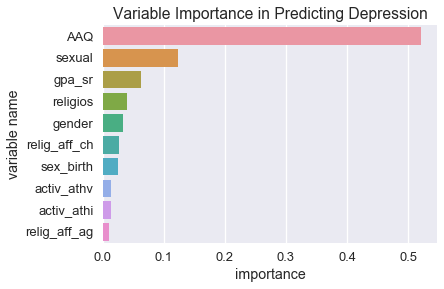

,variable name,importance
0,AAQ,0.504708
1,sexual,0.111366
2,gpa_sr,0.059653
3,gender,0.054187
4,sex_birth,0.042587
5,religios,0.031690
6,relig_aff_ch,0.019919
7,hours_work_paid,0.015288
8,disab_3,0.015002
9,activ_athi,0.013619


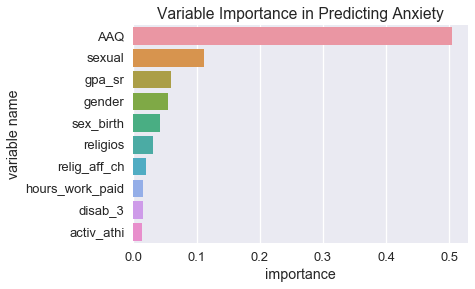

In [1025]:
# Print the name and gini importance of each feature
for clf in [dep_clf, anx_clf, flo_clf]:
    features = pd.DataFrame(sorted(zip(feat_cols, clf.feature_importances_),
                            key=lambda x: x[1], reverse=True), columns = ['variable name', 'importance'])
    #display(features.head(10))
    if clf == dep_clf or clf == anx_clf:
        display(features.head(10))
        sns.barplot(y = 'variable name', x = 'importance', data = features.head(10))
        plt.title('Variable Importance in Predicting Depression') if clf == dep_clf else plt.title('Variable Importance in Predicting Anxiety')
        plt.savefig('Dep_Var_Importance') if clf == dep_clf else plt.savefig('Anx_Var_Importance')
        plt.show()

### <span style="color:red">Interpretation: AAQ consistently comes out on top as BY FAR the most important feature</span>
- #### <span style="color:red">(10x more important than any demographic variable in predicting mental health outcomes)</span>

### d) test the accuracy of our full-feature classifier

In [1026]:
# Apply The Full Featured Classifier To The Test Data
y_pred_dep = dep_clf.predict(X_test)
y_pred_anx = anx_clf.predict(X_test)
y_pred_flo = flo_clf.predict(X_test)

# Print the Accuracy Of Our Full Feature Model
print('Depression Model Accuracy:', accuracy_score(y_depression_test, y_pred_dep))
print('Anxiety Model Accuracy:', accuracy_score(y_anxiety_test, y_pred_anx))
print('Flourishing Model Accuracy:', accuracy_score(y_flourish_test, y_pred_flo))

('Depression Model Accuracy:', 0.88781575037147098)
('Anxiety Model Accuracy:', 0.87704309063893016)
('Flourishing Model Accuracy:', 0.83320950965824669)


### e) perform cross-validation to check for possible overfitting

In [1027]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
for modelCV, trainingData in zip([dep_clf, anx_clf, flo_clf], [y_depression_train, y_anxiety_train, y_flourish_train]):
    results = model_selection.cross_val_score(modelCV, X_train, trainingData, cv=kfold, scoring='accuracy')
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.886
10-fold cross validation average accuracy: 0.874
10-fold cross validation average accuracy: 0.818


### f) compare performance to baseline measure (dummyClassifier)

In [1028]:
# Question: "what if we just guessed the *most common class* everytime?"
y_mode_pred_dep = DummyClassifier(strategy='most_frequent').fit(X_train, y_depression_train).predict(X_test)
y_mode_pred_anx = DummyClassifier(strategy='most_frequent').fit(X_train, y_anxiety_train).predict(X_test)
y_mode_pred_flo = DummyClassifier(strategy='most_frequent').fit(X_train, y_flourish_train).predict(X_test)

# use arrays of mode values to make baseline predictions
print('Depression BASELINE Accuracy:', accuracy_score(y_depression_test, y_mode_pred_dep))
print('Anxiety BASELINE Accuracy:', accuracy_score(y_anxiety_test, y_mode_pred_anx))
print('Flourishing BASELINE Accuracy:', accuracy_score(y_flourish_test, y_mode_pred_flo))

('Depression BASELINE Accuracy:', 0.54866270430906394)
('Anxiety BASELINE Accuracy:', 0.57206537890044573)
('Flourishing BASELINE Accuracy:', 0.56723625557206536)


### <span style="color:red"> The predictive models created above are 30-35% more accurate than their baseline measures: </span>
- #### <span style="color:red">Depression Classifer: ~89% accuracy</span> in predicting whether or not a student is clinically depressed
- #### <span style="color:red">Anxiety Classifer: ~87% accuracy </span>in predicting whether or not a student has general anxiety disorder
- #### <span style="color:red">Flourishing Classifer: ~82% accuracy </span>in predicting whether or not someone has positive mental health

## STEP #3: Optimize Classifier Models

### a) optimize hyperparameters using GridSearch

In [982]:
from sklearn.grid_search import GridSearchCV
 
rfc = RandomForestClassifier(n_jobs=-1, oob_score = True) 
 
# Use a grid over parameters of interest
param_grid = {"criterion" : ['gini', 'entropy'],
              "n_estimators" : [500, 1000],
              "max_depth" : [3, 5, 10, 15],
              "max_features" : [6, 8, 10, 12],
              "min_samples_leaf" : [10, 30, 50, 100]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5)
CV_rfc.fit(X_train, y_depression_train)
print CV_rfc.best_params_

KeyboardInterrupt: 

### b) identify and select the most important features

In [1029]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0
sfm = SelectFromModel(dep_clf, threshold=0.03)

# Train the selector
sfm.fit(X_train, y_depression_train)

# Print the names of the most important features
feat_cols_important = []
for feature_list_index in sfm.get_support(indices=True):
    feat_cols_important.append(feat_cols[feature_list_index])
    print(feat_cols[feature_list_index])

AAQ
gender
sexual
religios
gpa_sr


### c) create a dataset with only the most important features

In [1030]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

### d) train new classifiers using only the most important features ( + optimal hyperparameters)

In [1046]:
# Create a new random forest classifier for the most important features
dep_clf_imp = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 10, random_state=0, n_jobs=-1)

anx_clf_imp = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 10, random_state=0, n_jobs=-1)

flo_clf_imp = RandomForestClassifier(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 10, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
dep_clf_imp.fit(X_important_train, y_depression_train)
anx_clf_imp.fit(X_important_train, y_anxiety_train)
flo_clf_imp.fit(X_important_train, y_anxiety_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### e) extract feature importances

,variable name,importance
0,AAQ,0.875508
1,Sexuality,0.069094
2,GPA,0.031934
3,Religiousness,0.013286
4,Gender,0.010178


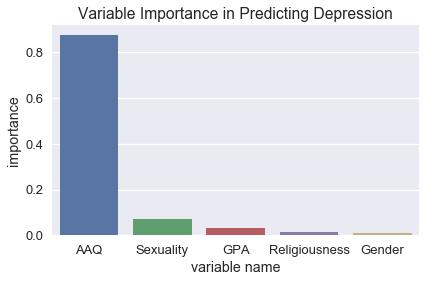

,variable name,importance
0,AAQ,0.878888
1,Sexuality,0.059770
2,GPA,0.027656
3,Gender,0.025093
4,Religiousness,0.008593


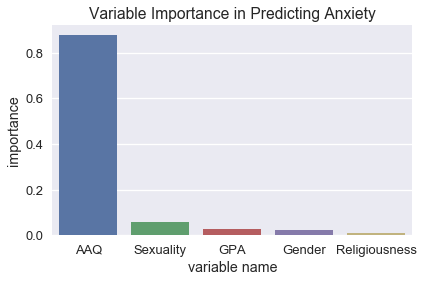

In [1080]:
# Print the name and gini importance of each feature
for clf in [dep_clf_imp, anx_clf_imp, flo_clf_imp]:
    features = pd.DataFrame(sorted(zip(feat_cols_important, clf.feature_importances_),
                            key=lambda x: x[1], reverse=True), columns = ['variable name', 'importance'])
    
    #display(features.head(10))
    if clf == dep_clf_imp or clf == anx_clf_imp:
        features['variable name'] = ['AAQ', 'Sexuality','GPA', 'Religiousness','Gender'] if clf == dep_clf_imp else ['AAQ', 'Sexuality','GPA', 'Gender','Religiousness']
        display(features.head(10))
        sns.barplot(x = 'variable name', y = 'importance', data = features.head(10))
        plt.title('Variable Importance in Predicting Depression') if clf == dep_clf_imp else plt.title('Variable Importance in Predicting Anxiety')
        plt.tight_layout(pad=1)
        plt.savefig('Dep_Var_Importance2') if clf == dep_clf_imp else plt.savefig('Anx_Var_Importance2')
        plt.show()

### f) test the accuracy of our limited-feature model

In [1048]:
# Apply The Full Featured Classifier To The Test Data
y_pred_dep_imp = dep_clf_imp.predict(X_important_test)
y_pred_anx_imp = anx_clf_imp.predict(X_important_test)
y_pred_flo_imp = flo_clf_imp.predict(X_important_test)

# Print the Accuracy Of Our Full Feature Model
print('Depression Model Accuracy:', accuracy_score(y_depression_test, y_pred_dep_imp))
print('Anxiety Model Accuracy:', accuracy_score(y_anxiety_test, y_pred_anx_imp))
print('Flourishing Model Accuracy:', accuracy_score(y_anxiety_test, y_pred_flo_imp))

('Depression Model Accuracy:', 0.88893016344725106)
('Anxiety Model Accuracy:', 0.88521545319465078)
('Flourishing Model Accuracy:', 0.88521545319465078)


### g) perform cross-validation to check for possible overfitting

In [1068]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
for modelCV, trainingData in zip([dep_clf_imp, anx_clf_imp, flo_clf_imp], [y_depression_train, y_anxiety_train]):
    results = model_selection.cross_val_score(modelCV, X_train, trainingData, cv=kfold, scoring='accuracy')
    print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.886
10-fold cross validation average accuracy: 0.876


### h) compare performance to baseline measure (dummyClassifier)

In [1069]:
# Question: "what if we just guessed the *most common class* everytime?"
y_mode_pred_dep = DummyClassifier(strategy='most_frequent').fit(X_important_train, y_depression_train).predict(X_important_test)
y_mode_pred_anx = DummyClassifier(strategy='most_frequent').fit(X_important_train, y_anxiety_train).predict(X_important_test)
y_mode_pred_flo = DummyClassifier(strategy='most_frequent').fit(X_important_train, y_flourish_train).predict(X_important_test)

# use arrays of mode values to make baseline predictions
print('Depression BASELINE Accuracy:', accuracy_score(y_depression_test, y_mode_pred_dep))
print('Anxiety BASELINE Accuracy:', accuracy_score(y_anxiety_test, y_mode_pred_anx))
print('Flourish BASELINE Accuracy:', accuracy_score(y_flourish_test, y_mode_pred_flo))

('Depression BASELINE Accuracy:', 0.54866270430906394)
('Anxiety BASELINE Accuracy:', 0.57206537890044573)
('Flourish BASELINE Accuracy:', 0.56723625557206536)


### <span style="color:red"> The predictive models created above are 35-40% more accurate than their baseline measures: </span>
- #### <span style="color:red">Depression Classifer: ~89% accuracy</span> in predicting whether or not a student is clinically depressed
- #### <span style="color:red">Anxiety Classifer: ~88% accuracy </span>in predicting whether or not a student has general anxiety disorder
- #### <span style="color:red">Flourishing Classifer: ~88% accuracy </span>in predicting whether or not someone has positive mental health

## STEP #4: Train a Random Forest Regressor

### a) do some quick cleaning

In [1070]:
# combine all variables (X's and Y's) into one dataframe
all_variables_reg = pd.concat([X, Y_flourish, Y_depression, Y_anxiety], axis = 1)

In [1071]:
# remove all rows with any NaN
print('shape before removing NaNs:', all_variables_reg.shape)
all_variables_reg = all_variables_reg.dropna(axis=0, how='any')
print('shape after removing NaNs:', all_variables_reg.shape) # NOTE: 25,000+ dropped rows were due to AAQ

('shape before removing NaNs:', (45756, 99))
('shape after removing NaNs:', (8972, 99))


In [1072]:
# split big dataframe back up
X = all_variables.drop(labels=['flourish', 'deprawsc', 'anx_score'], axis=1)
Y_flourish_reg = all_variables['flourish']
Y_depression_reg = all_variables['deprawsc']
Y_anxiety_reg = all_variables['anx_score']

### b) split data into train & test sets

In [1073]:
# split the data into training and test sets
X_train_reg, X_test_reg = train_test_split(X, test_size=0.3, random_state=0)
y_flourish_train_reg, y_flourish_test_reg = train_test_split(Y_flourish_reg, test_size=0.3, random_state=0)
y_depression_train_reg, y_depression_test_reg = train_test_split(Y_depression_reg, test_size=0.3, random_state=0)
y_anxiety_train_reg, y_anxiety_test_reg = train_test_split(Y_anxiety_reg, test_size=0.3, random_state=0)

### c) create and train the classifiers

In [1074]:
# Create random forest regressors
dep_clf_reg = RandomForestRegressor(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

anx_clf_reg = RandomForestRegressor(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

flo_clf_reg = RandomForestRegressor(n_estimators=1000, max_features = "auto", max_depth = 5,
                             min_samples_leaf = 100, random_state=0, n_jobs=-1)

In [1075]:
# Train the classifiers on all three outcomes
dep_clf_reg.fit(X_train_reg, y_depression_train_reg)
anx_clf_reg.fit(X_train_reg, y_anxiety_train_reg)
flo_clf_reg.fit(X_train_reg, y_flourish_train_reg)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

### d) extract feature importances

,variable name,importance
0,AAQ,0.977959
1,gpa_sr,0.008726
2,educ_par2,0.002478
3,hours_work_paid,0.002453
4,sexual,0.002256
5,educ_par1,0.002131
6,residenc,0.000862
7,religios,0.000453
8,age,0.000416
9,transfer,0.000363


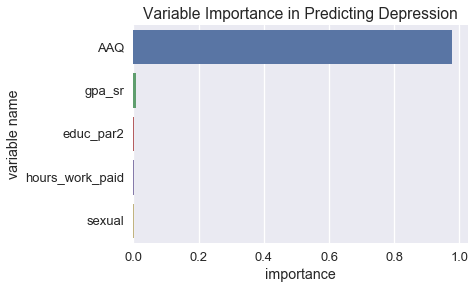

,variable name,importance
0,AAQ,0.974765
1,hours_work_paid,0.007227
2,gender,0.003391
3,gpa_sr,0.003017
4,residenc,0.002570
5,educ_par2,0.001872
6,educ_par1,0.001828
7,sex_birth,0.001565
8,relship,0.000748
9,timestud,0.000509


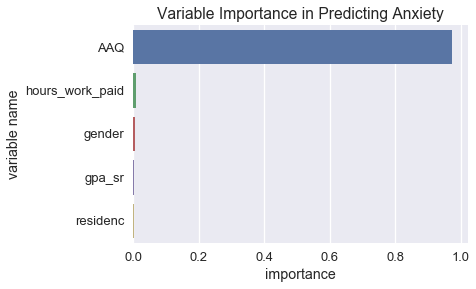

In [1076]:
# Print the name and gini importance of each feature
for clf in [dep_clf_reg, anx_clf_reg, flo_clf_reg]:
    features = pd.DataFrame(sorted(zip(feat_cols, clf.feature_importances_),
                            key=lambda x: x[1], reverse=True), columns = ['variable name', 'importance'])
    
    #display(features.head(10))
    if clf == dep_clf_reg or clf == anx_clf_reg:
        display(features.head(10))
        sns.barplot(y = 'variable name', x = 'importance', data = features.head(5))
        plt.title('Variable Importance in Predicting Depression') if clf == dep_clf_reg else plt.title('Variable Importance in Predicting Anxiety')
        plt.savefig('Dep_Var_Importance_Reg') if clf == dep_clf_reg else plt.savefig('Anx_Var_Importance_Reg')
        plt.show()

### <span style="color:red">Interpretation: AAQ consistently comes out on top as BY FAR the most important feature</span>
- #### <span style="color:red">(10x more important than any demographic variable in predicting mental health outcomes)</span>

### e) test the performance of our full-feature classifier

In [1077]:
# create RMSE function as absolute measure of fit
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [1078]:
# Apply The Full Featured Classifier To The Test Data
y_pred_dep_reg = dep_clf_reg.predict(X_test_reg)
y_pred_anx_reg = anx_clf_reg.predict(X_test_reg)
y_pred_flo_reg = flo_clf_reg.predict(X_test_reg)

# Measure Goodness-of-Fit
print("Depression Model R-squared:", dep_clf_reg.score(X_test_reg, y_depression_test_reg))
print("Anxiety Model R-squared:", anx_clf_reg.score(X_test_reg, y_anxiety_test_reg))
print("Flourishing Model R-squared:", flo_clf_reg.score(X_test_reg, y_flourish_test_reg))
print('\n')
print("Depression Model RMSE:", rmse(y_pred_dep_reg, y_depression_test_reg))
print("Anxiety Model RMSE:", rmse(y_pred_anx_reg, y_anxiety_test_reg))
print("Flourishing Model RMSE:", rmse(y_pred_flo_reg, y_anxiety_test_reg))

('Depression Model R-squared:', 0.66707210896667046)
('Anxiety Model R-squared:', 0.67471282647701258)
('Flourishing Model R-squared:', 0.45206679662107607)


('Depression Model RMSE:', 4.5249371134473169)
('Anxiety Model RMSE:', 3.9732551974363814)
('Flourishing Model RMSE:', 38.36218950758478)


#### <span style="color:red">R-squared</span> measures the <span style="color:red">proportion of variability</span> in Y explained by the regression model (a useful benchmark for comparing models)
#### <span style="color:red">RMSE</span> measures the <span style="color:red">standard deviation of the residuals</span> (the spread of the points about the fitted regression line)

### f) compare performance to baseline measure (dummyRegressor)

In [1079]:
# Question: "what if we just guessed the *median value* everytime?"
y_median_pred_dep_reg = DummyRegressor(strategy='median').fit(X_train_reg, y_depression_train_reg).predict(X_test_reg)
y_median_pred_anx_reg = DummyRegressor(strategy='median').fit(X_train_reg, y_anxiety_train_reg).predict(X_test_reg)
y_median_pred_flo_reg = DummyRegressor(strategy='median').fit(X_train_reg, y_flourish_train_reg).predict(X_test_reg)

# use arrays of median values to make baseline predictions
print('Depression BASELINE R-Squared', DummyRegressor(strategy='median').fit(X_train_reg, y_depression_train_reg).score(X_test_reg, y_depression_test_reg))
print('Anxiety BASELINE R-Squared', DummyRegressor(strategy='median').fit(X_train_reg, y_anxiety_train_reg).score(X_test_reg, y_anxiety_test_reg))
print('Flourishing BASELINE R-Squared', DummyRegressor(strategy='median').fit(X_train_reg, y_flourish_train_reg).score(X_test_reg, y_flourish_test_reg))
print('\n')
print('Depression BASELINE RMSE:', rmse(y_median_pred_dep_reg, y_depression_test_reg))
print('Anxiety BASELINE RMSE:', rmse(y_median_pred_anx_reg, y_anxiety_test_reg))
print('Flourishing BASELINE RMSE:', rmse(y_median_pred_flo_reg, y_flourish_test_reg))

('Depression BASELINE R-Squared', -0.32434011555204822)
('Anxiety BASELINE R-Squared', -0.22440938066905858)
('Flourishing BASELINE R-Squared', -0.18083339171710611)


('Depression BASELINE RMSE:', 9.0247924986332961)
('Anxiety BASELINE RMSE:', 7.7086142740927119)
('Flourishing BASELINE RMSE:', 11.72321961568168)


### <span style="color:red"> The predictive models created above are 95-105% better fits than their baseline measures: </span>
- #### <span style="color:red">Depression Regressor: R-Squared = 0.73 // RMSE = 4.10 </span> in predicting a student's depression level
- #### <span style="color:red">Anxiety Regressor: R-Squared = 0.71 // RMSE = 3.77 </span>in predicting a student's anxiety level
- #### <span style="color:red">Flourishing Regressor: R-Squared = 0.49 // RMSE = 38.5 </span>in predicting a student's psychological well-being level 

## STEP #4: Logistic Regression for Psychological Flexibility & Depression

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import cross_val_score

In [779]:
# split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.3, random_state=0)
y_flourish_train, y_flourish_test = train_test_split(Y_flourish_cats, test_size=0.3, random_state=0)
y_depression_train, y_depression_test = train_test_split(Y_depression_cats, test_size=0.3, random_state=0)
y_anxiety_train, y_anxiety_test = train_test_split(Y_anxiety_cats, test_size=0.3, random_state=0)

### a) Run statsmodel to generate summary statistics

In [1116]:
# run statsmodel to generate logistic regression summary statistics
logit_model = sm.Logit(y_depression_train.reshape(-1,1), sm.add_constant(X_train['AAQ'].reshape(-1,1)))
results = logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.292482
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6280
Model:                          Logit   Df Residuals:                     6278
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Dec 2017   Pseudo R-squ.:                  0.5757
Time:                        20:01:10   Log-Likelihood:                -1836.8
converged:                       True   LL-Null:                       -4328.8
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8628      0.139    -42.050      0.000      -6.136      -5.590
x1             0.2659      0.

In [1117]:
print('AAQ Odds Ratio (sklearn):', np.exp(results.params[1]))

('AAQ Odds Ratio (sklearn):', 1.3046626538540764)


### <span style="color:red">Model Interpretation:</span>
#### <span style="color:red">For every 1 unit increase in a student's AAQ score, we expect their odds of being depressed to increase by 30%</span>

### b) Visualize predicted probabilities of depression over AAQ spectrum

In [1101]:
# run new Logistic Regression model with sklearn
logreg = LogisticRegression()
logreg.fit(X_train.AAQ.reshape(-1,1), y_depression_train);

In [1109]:
# create dataframe of AAQ and predicted probability of depression
df = pd.concat([pd.Series(np.reshape(X_train.AAQ.reshape(-1,1), [6280,])),
                pd.Series(logreg.predict_proba(X_train.AAQ.reshape(-1,1))[:, 1])], axis=1)
df.columns = ['AAQ', 'P(depression)']

# add column for probability difference
df2 = pd.DataFrame(df.groupby(['AAQ'])['P(depression)'].mean()).reset_index()
df2['prob diff'] = df2['P(depression)'] - df2['P(depression)'].shift(1)
df2.loc[6:26,:]

,AAQ,P(depression),prob diff
6,10.0,0.041451,0.009221
7,11.0,0.053165,0.011714
8,12.0,0.067955,0.014790
9,13.0,0.086484,0.018529
10,14.0,0.109471,0.022987
11,15.0,0.137647,0.028176
12,16.0,0.171678,0.034031
13,17.0,0.212053,0.040375
14,18.0,0.258955,0.046902
15,19.0,0.312122,0.053167


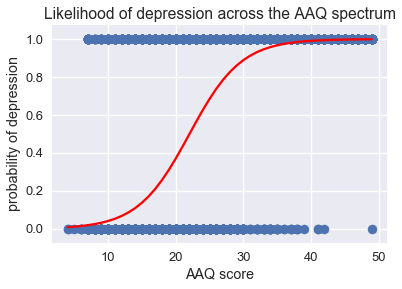

In [1103]:
# plot the mean predicted probability of depression across the spectrum of AAQ
plt.scatter(X_train.AAQ.reshape(-1,1), y_depression_train.reshape(-1,1))
plt.plot(df.groupby(['AAQ'])['P(depression)'].mean(), color='red')
plt.xlabel('AAQ score')
plt.ylabel('probability of depression');
plt.title('Likelihood of depression across the AAQ spectrum');

### <span style="color:red"> There is a very strong relationship between a students' AAQ score and their likelihood of being depressed</span>

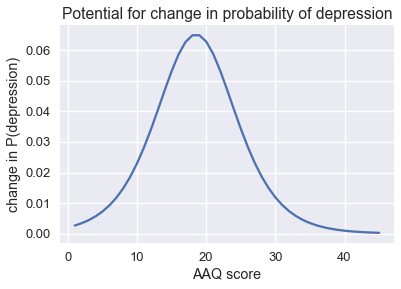

In [1104]:
plt.plot(df2['prob diff'])
plt.xlabel('AAQ score')
plt.ylabel('change in P(depression)')
plt.title('Potential for change in probability of depression');

### <span style="color:red"> Students with AAQ scores between 15-30 have the most potential for change in their depression probability </span>

### Test model accuracy

In [858]:
y_dep_preds = logreg.predict(X_test.AAQ.reshape(-1,1))

print('Depression Model Accuracy:', accuracy_score(y_depression_test, y_dep_preds))

('Depression Model Accuracy:', 0.88707280832095092)


### <span style="color:red">With an accuracy of 88.7%, the model is performing incredibly well</span>

### Perform cross validation for check for overfitting

In [859]:
# run cross validation to check for overfitting
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train.AAQ.reshape(-1,1), y_depression_train.reshape(-1,1), cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.884


### <span style="color:red">With an average CV accuracy of 88.4%, the model does not appear to be overfitting to the training data</span>

### Generate confusion matrix

In [860]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_depression_test, y_dep_preds)
confusion_df = pd.DataFrame(confusion_matrix, index = ['Actual: Depressed', 'Actual: Not Depressed'], columns = ['Predicted: Depressed', 'Predicted: Not Depressed'])
print(confusion_df)

                       Predicted: Depressed  Predicted: Not Depressed
Actual: Depressed                      1349                       128
Actual: Not Depressed                   176                      1039


### Calculate precision, recall, f1-score, etc.

In [861]:
print(classification_report(y_depression_test, y_dep_preds))

             precision    recall  f1-score   support

          0       0.88      0.91      0.90      1477
          1       0.89      0.86      0.87      1215

avg / total       0.89      0.89      0.89      2692



- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall.
- The support is the number of occurrences of each class in y_test.

###  <span style="color:red">Precision = 89 %  //  Recall = 89%  //  F1-Score = 89%</span>

### Graph ROC Curve

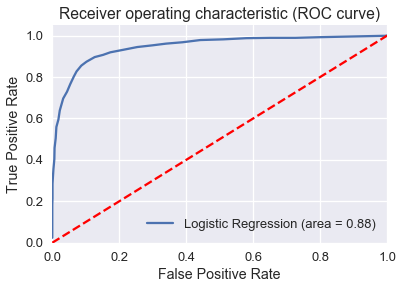

In [978]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_depression_test, logreg.predict(X_test.AAQ.reshape(-1,1)))
fpr, tpr, thresholds = roc_curve(y_depression_test, logreg.predict_proba(X_test.AAQ.reshape(-1,1))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### <span style="color:green">All in all, this logistic regression model appears to conclude that psychological flexibility is a strong, accurate, and positive predictor of depression in American college students. </span>

## STEP #5: Logistic Regression for Psychological Flexibility & Anxiety

### a) Run statsmodel to generate summary statistics

In [1118]:
# run statsmodel to generate logistic regression summary statistics
logit_model = sm.Logit(y_anxiety_train.reshape(-1,1), sm.add_constant(X_train['AAQ'].reshape(-1,1)))
results = logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.295717
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6280
Model:                          Logit   Df Residuals:                     6278
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Dec 2017   Pseudo R-squ.:                  0.5666
Time:                        20:03:18   Log-Likelihood:                -1857.1
converged:                       True   LL-Null:                       -4284.7
                                        LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9699      0.141    -42.205      0.000      -6.247      -5.693
x1             0.2554      0.

In [1119]:
print('AAQ Odds Ratio (sklearn):', np.exp(results.params[1]))

('AAQ Odds Ratio (sklearn):', 1.2910059309302317)


### <span style="color:red">Model Interpretation:</span>
#### <span style="color:red">For every 1 unit increase in a student's AAQ score, we expect their odds of being clinically anxious to increase by 29%</span>

### b) Visualize predicted probabilities of depression over AAQ spectrum

In [1120]:
# run new Logistic Regression model with sklearn
logreg = LogisticRegression()
logreg.fit(X_train.AAQ.reshape(-1,1), y_anxiety_train);

In [1124]:
# create dataframe of AAQ and predicted probability of depression
df = pd.concat([pd.Series(np.reshape(X_train.AAQ.reshape(-1,1), [6280,])),
                pd.Series(logreg.predict_proba(X_train.AAQ.reshape(-1,1))[:, 1])], axis=1)
df.columns = ['AAQ', 'P(anxiety)']

# add column for probability difference
df2 = pd.DataFrame(df.groupby(['AAQ'])['P(anxiety)'].mean()).reset_index()
df2['prob diff'] = df2['P(anxiety)'] - df2['P(anxiety)'].shift(1)
df2.loc[10:30,:]

,AAQ,P(anxiety),prob diff
10,14.0,0.087600,0.018067
11,15.0,0.109806,0.022207
12,16.0,0.136799,0.026992
13,17.0,0.169165,0.032366
14,18.0,0.207350,0.038185
15,19.0,0.251544,0.044195
16,20.0,0.301575,0.050030
17,21.0,0.356812,0.055237
18,22.0,0.416139,0.059326
19,23.0,0.477998,0.061860


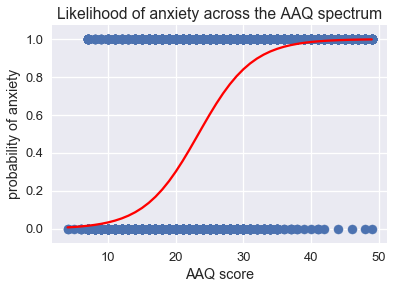

In [1122]:
# plot the mean predicted probability of depression across the spectrum of AAQ
plt.scatter(X_train.AAQ.reshape(-1,1), y_anxiety_train.reshape(-1,1))
plt.plot(df.groupby(['AAQ'])['P(anxiety)'].mean(), color='red')
plt.xlabel('AAQ score')
plt.ylabel('probability of anxiety');
plt.title('Likelihood of anxiety across the AAQ spectrum');

### <span style="color:red"> There is a very strong relationship between a students' AAQ score and their likelihood of being anxious</span>

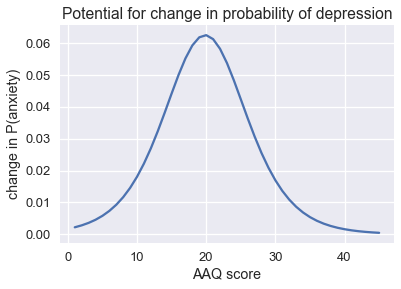

In [1123]:
plt.plot(df2['prob diff'])
plt.xlabel('AAQ score')
plt.ylabel('change in P(anxiety)')
plt.title('Potential for change in probability of depression');

### <span style="color:red"> Students with AAQ scores between 18-31 have the most potential for change in their anxiety probability </span>

### Test model accuracy

In [1125]:
y_anx_preds = logreg.predict(X_test.AAQ.reshape(-1,1))

print('Depression Model Accuracy:', accuracy_score(y_anxiety_test, y_anx_preds))

('Depression Model Accuracy:', 0.88335809806835064)


### <span style="color:red">With an accuracy of 88.3%, the model is performing incredibly well</span>

### Perform cross validation for check for overfitting

In [1126]:
# run cross validation to check for overfitting
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
results = model_selection.cross_val_score(modelCV, X_train.AAQ.reshape(-1,1), y_anxiety_train.reshape(-1,1), cv=kfold, scoring='accuracy')
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.877


### <span style="color:red">With an average CV accuracy of 87.7%, the model does not appear to be overfitting to the training data</span>

### Generate confusion matrix

In [1128]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_anxiety_test, y_anx_preds)
confusion_df = pd.DataFrame(confusion_matrix, index = ['Actual: Anxious', 'Actual: Not Anxious'], columns = ['Predicted: Anxious', 'Predicted: Not Anxious'])
print(confusion_df)

                     Predicted: Anxious  Predicted: Not Anxious
Actual: Anxious                    1403                     137
Actual: Not Anxious                 177                     975


### Calculate precision, recall, f1-score, etc.

In [1129]:
print(classification_report(y_anxiety_test, y_anx_preds))

             precision    recall  f1-score   support

          0       0.89      0.91      0.90      1540
          1       0.88      0.85      0.86      1152

avg / total       0.88      0.88      0.88      2692



- The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
- The recall is intuitively the ability of the classifier to find all the positive samples.
- The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall.
- The support is the number of occurrences of each class in y_test.

###  <span style="color:red">Precision = 88 %  //  Recall = 88%  //  F1-Score = 88%</span>

### Graph ROC Curve

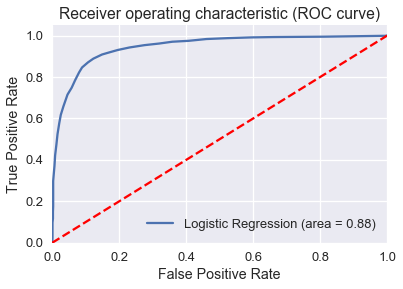

In [1130]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_anxiety_test, logreg.predict(X_test.AAQ.reshape(-1,1)))
fpr, tpr, thresholds = roc_curve(y_anxiety_test, logreg.predict_proba(X_test.AAQ.reshape(-1,1))[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC curve)')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### <span style="color:green">All in all, this logistic regression model appears to conclude that psychological flexibility is a strong, accurate, and positive predictor of anxiety in American college students. </span>